<a href="https://colab.research.google.com/github/uggg179/Restaurant_Review_Sentimental-Analysis/blob/main/Restaurant_Review_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
odf = pd.read_csv('/content/drive/MyDrive/Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1.0, 'How helpful users find among user scores')

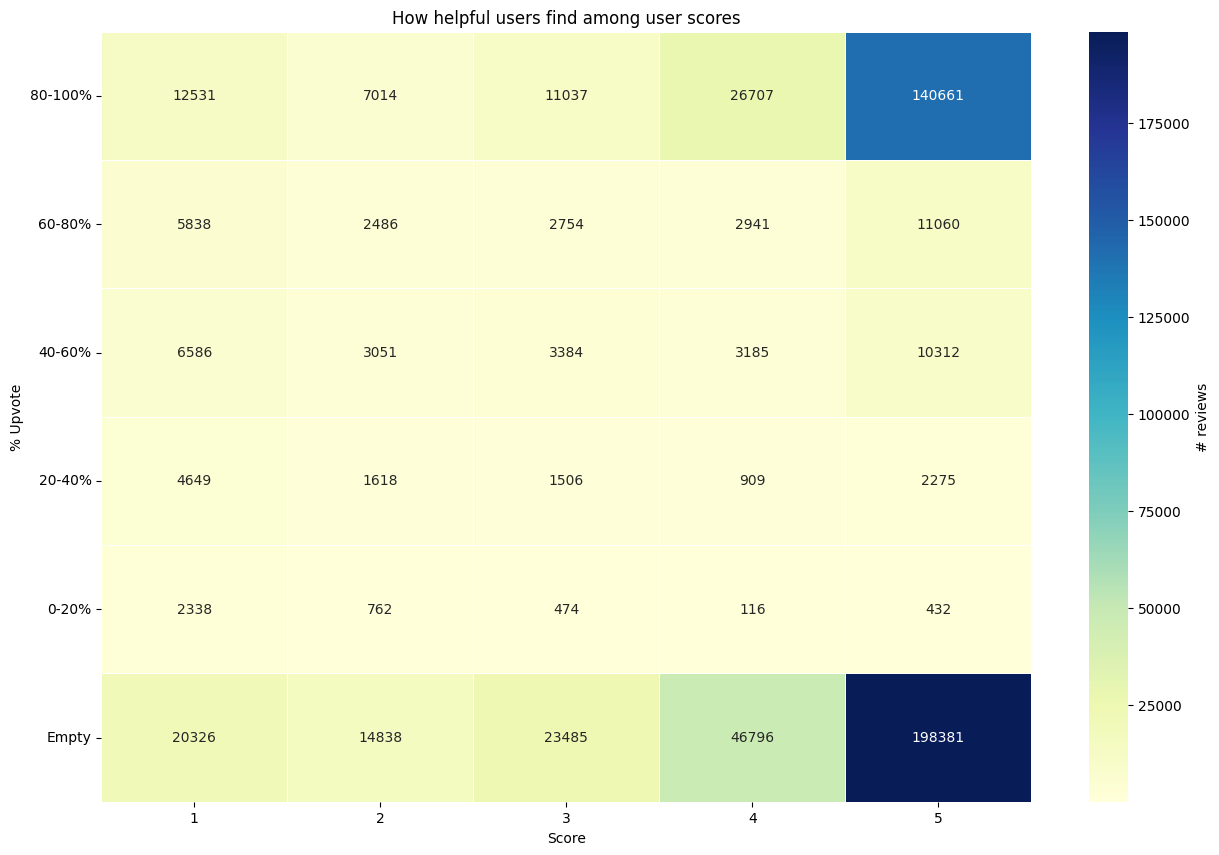

In [ ]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = "YlGnBu", linewidths =.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Key message from above:

Reviews are skewed towards positive
More than half of the reviews are with zero votes
Many people agree with score 5 reviews
Then we get rid of score 3 reviews(Neutral), and separate the remaining reviews into binary class(1 = positive, 0 = negative):

In [ ]:
df = odf[odf['Score'] !=3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

# **Score Prediction**

Logistic regression model on word count

In [ ]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):

    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))

    if coef_show == 1:
        w = model.get_feature_names_out()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')
        print(coeff_df.tail(20).to_string(index=False))


text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9357874237375812

-Top 20 positive-
       Word  Coefficient
 pleasantly     4.233988
   downside     3.126420
  addicting     2.959068
   drawback     2.670239
  skeptical     2.511270
     resist     2.379871
 economical     2.265789
       whim     2.236301
   soothing     2.218977
    easiest     2.206777
     hooked     2.174912
    welcome     2.084585
  delighted     2.079272
      meets     1.976601
        yay     1.976106
wonderfully     1.970862
  excellent     1.965659
    worries     1.945496
exceptional     1.942430
     delish     1.933981

-Top 20 negative-
         Word  Coefficient
        ruins    -2.306015
       lacked    -2.327670
        blech    -2.334804
   unfinished    -2.350162
   unbearable    -2.356371
          ick    -2.419503
   overpowers    -2.489050
  unappealing    -2.531981
  disapointed    -2.558029
      defeats    -2.614594
   returnable    -2.684543
     mediocre    -2.736155
       ripoff    -2.843889
disappointing    -2.9432

Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficient are not meaningful.

Let's also look at the base line accuracy (predicting with majority class, in this case positive class):

In [ ]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.8437324082949168


**Logistic regression model on TFIDF**

In [ ]:
tfdif = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfdif, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9347528412980967

-Top 20 positive-
      Word  Coefficient
     great    13.829271
 delicious    12.266400
      best    11.950646
   perfect    10.603334
 excellent     9.912412
     loves     9.589463
    highly     8.900379
      love     8.377649
 wonderful     8.016587
   amazing     7.610002
pleasantly     7.505516
   awesome     7.374907
      good     7.331522
      nice     7.140911
    hooked     7.140227
  favorite     6.901615
   pleased     6.833933
    smooth     6.811193
     yummy     6.728316
 fantastic     6.521717

-Top 20 negative-
          Word  Coefficient
  unacceptable    -5.621037
          poor    -5.689809
          yuck    -5.885682
   undrinkable    -5.934016
         worse    -6.123684
         stale    -6.125437
         bland    -6.378601
    disgusting    -6.411666
          weak    -6.466382
         threw    -6.658506
     tasteless    -6.660641
        return    -6.753367
 unfortunately    -7.482973
      horrible    -7.829670
dis

Accuracy is roughly the same - 93.5%. However we notice that significant words make much more sense now, with higher coefficient magnitude as well!

**Logistic regression model on TFIDF + ngram**

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9457604941652593

-Top 20 positive-
     Word  Coefficient
    great    20.855565
     best    17.937496
delicious    17.013618
  perfect    14.556857
    loves    13.740189
     love    13.215917
excellent    13.073653
     good    11.469407
wonderful    11.238944
     nice    10.906891
 favorite    10.679330
  amazing     9.604788
  awesome     9.298551
     easy     9.169952
    happy     8.978891
  pleased     8.815757
   smooth     8.639700
    yummy     8.542115
    tasty     8.471431
   highly     8.434181

-Top 20 negative-
          Word  Coefficient
         maybe    -7.892227
        hoping    -8.070309
     tasteless    -8.229962
         money    -8.262063
         worse    -8.301065
       thought    -8.488736
    disgusting    -8.713986
         bland    -9.136684
         threw    -9.280872
         stale    -9.982482
          weak   -10.106826
        return   -10.123877
disappointment   -10.315521
 unfortunately   -10.813910
      horrible   -11.312

Adding ngram parameter, we are able to understand phrase like "not good". Therefore the accuracy goes up a bit to 94.5%. We can see words like "tasty, yummy" in the result.

# **Upvote prediction**

**Data preview**

This study is to see whether is pattern found for unpopular(downvote) comments by users(might be used to boost sales). We will be focusing on score 5 reviews, and get rid of comments with neutral votes:*italicized text*

In [ ]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1.0    151721
0.0      2707
Name: % Upvote, dtype: int64


The traget class is highly skewed to positive (upvotes). Let's resample the data to get balanced data:

In [ ]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


**Logic regression model on word count**

In [ ]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 15630
# train records: 4060
# test records: 1354
Model Accuracy: 0.7031019202363368

-Top 20 positive-
          Word  Coefficient
      quantity     1.711828
          kona     1.520372
      fabulous     1.507107
          beat     1.399835
          rate     1.179806
        plenty     1.169436
     allergies     1.108479
          chai     1.087268
        ginger     1.048022
         worth     1.039804
         keeps     1.036983
        subtle     1.031925
         close     1.022330
          pops     0.993477
         boxed     0.988707
         touch     0.978035
recommendation     0.977167
       special     0.966590
          teas     0.966269
        repeat     0.965184

-Top 20 negative-
       Word  Coefficient
       yoga    -0.973988
      maybe    -0.991080
  satisfied    -0.994982
   bergamot    -1.014498
     joints    -1.017262
         18    -1.020590
         80    -1.035164
      shape    -1.041167
    markets    -1.057315
traditional    -1.057890
   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic regression model on TFIDF + ngram**

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 138794
# train records: 4060
# test records: 1354
Model Accuracy: 0.7104874446085672

-Top 20 positive-
     Word  Coefficient
     food     1.593864
   flavor     1.541318
    chips     1.419305
      dog     1.218943
    worth     1.217579
    blend     1.119342
wonderful     1.111773
     just     1.093238
     salt     1.085150
     teas     1.062115
    fresh     1.032183
   ginger     1.005786
       ve     0.950679
      tea     0.939138
    tried     0.931638
     chai     0.904205
      mix     0.893444
  flavors     0.884180
  started     0.882386
  chicken     0.866372

-Top 20 negative-
         Word  Coefficient
          pod    -0.828316
         good    -0.836143
         cans    -0.854713
       seller    -0.870867
       lipton    -0.872283
         yoga    -0.901258
product great    -0.918776
        wrong    -0.942848
        taste    -0.989462
 great coffee    -0.995981
       cereal    -1.070193
      service    -1.087818
        order    -1.150586
    

Similar to count metric, the accuracy isn't high and words not meaningful.

** Study on non-context features**

Let's look at some examples of upvote and downvote comments:

In [ ]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples: ')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])

Downvote score 5 comments examples: 
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object


Time to extract some possible features:

In [ ]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c =='!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        83.927226  83.207240
capital_count     19.252678  12.951238
question_mark      0.180273   0.073513
exclamation_mark   0.906169   0.916882
punctuation       22.482822  18.037311


Now we train the model to predict:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5967503692762186
SVM accuracy: 0.5797636632200887


Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.

# **In-depth study on user behaviour**

This analysis will be carried out to focus on one specific user, on what he/she likes in terms of fine food, based on the reviews he/she had given in the past. This can be expanded to all users later on.

First let's look at how many reviews each user gave in the past:

In [ ]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending=False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:

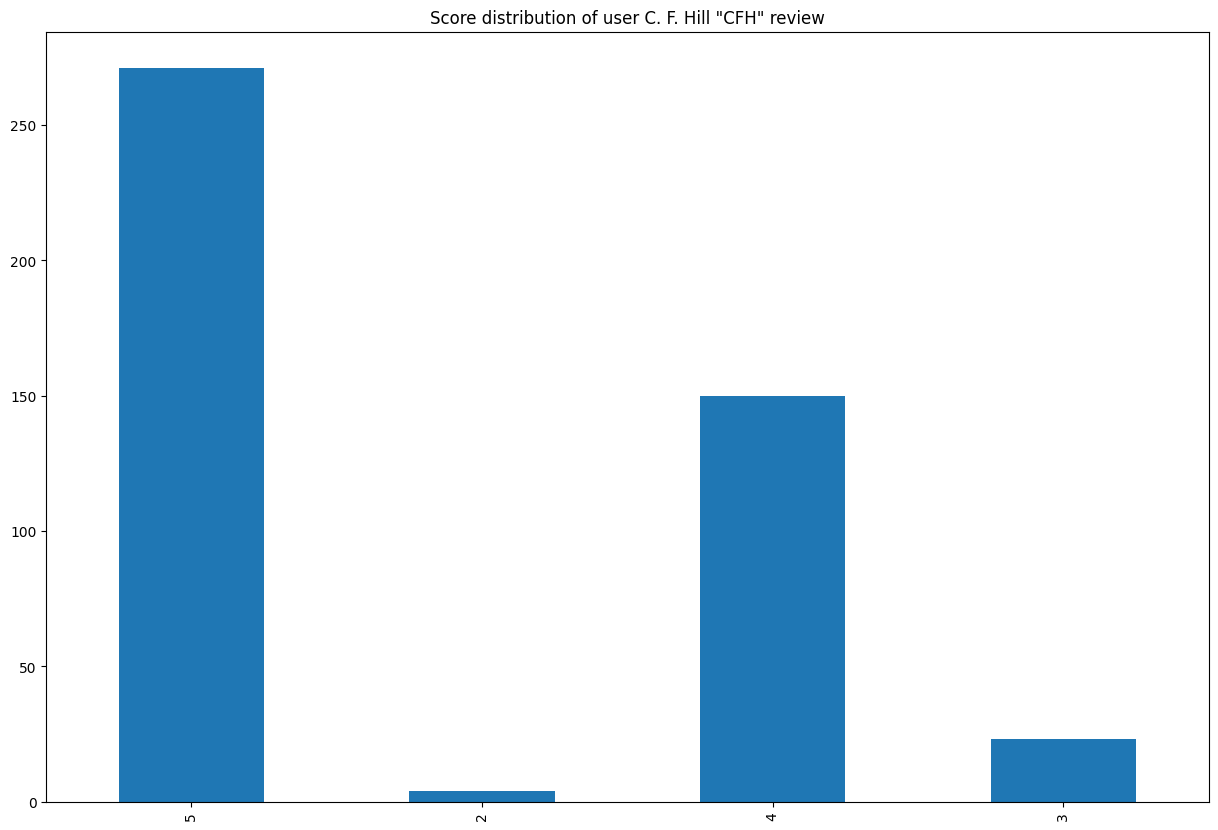

In [ ]:
def plot_user(UserId):
  df_1user = odf[odf['UserId'] == UserId]['Score']
  df_1user_plot = df_1user.value_counts(sort=False)
  ax = df_1user_plot.plot(kind = 'bar', figsize = (15, 10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's look into that:

In [ ]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


A. Benett seems a good target:

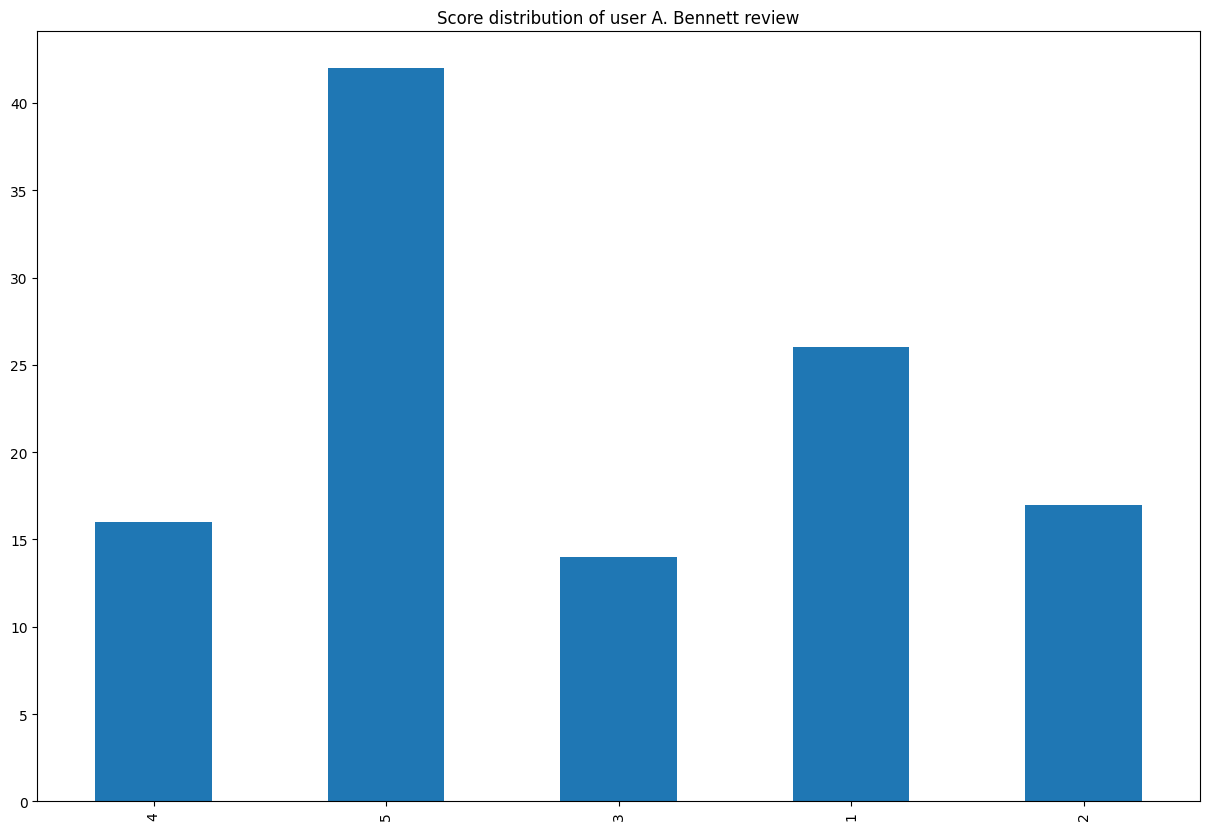

In [17]:
plot_user('A2M9D9BDHONV3Y')

In [18]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


He seems like a better analysis target! Now let's look deep into his reviews

In [19]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']

    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)

    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
                    Phrase  Count Occur %
0             (never, buy)     11  42.31%
1           (buy, product)      9  34.62%
2  (monosodium, glutamate)      8  30.77%
3    (never, buy, product)      8  30.77%
4         (dry, tasteless)      7  26.92%
5            (decide, try)      7  26.92%
6          (picture, look)      7  26.92%
score 2 reviews most popular 2-gram / 3-gram:


<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-19-7bdee30b8396>:35: Futu

                  Phrase  Count Occur %
0          (sauce, ruin)      8  47.06%
1   (sauce, ruin, whole)      8  47.06%
2          (ruin, whole)      8  47.06%
3            (give, try)      7  41.18%
4        (product, ever)      6  35.29%
5             (n't, buy)      6  35.29%
6           (get, wrong)      5  29.41%
7           (...., give)      5  29.41%
8          (taste, like)      5  29.41%
9      (give, try, like)      5  29.41%
10     (buy, particular)      5  29.41%
11           (try, like)      5  29.41%
12     (...., give, try)      5  29.41%
13            (n't, get)      5  29.41%
14     (n't, get, wrong)      5  29.41%
score 3 reviews most popular 2-gram / 3-gram:
          Phrase  Count Occur %
0  (taste, like)      4  28.57%
1   (whole, lot)      4  28.57%
score 4 reviews most popular 2-gram / 3-gram:


<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-19-7bdee30b8396>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)


                Phrase  Count Occur %
0  (highly, recommend)      6   37.5%
1         (side, dish)      5  31.25%
2       (potato, chip)      4   25.0%
score 5 reviews most popular 2-gram / 3-gram:
                Phrase  Count Occur %
0  (highly, recommend)     18  42.86%


Seems like A. bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). But Sample size is very small.